In [1]:
import numpy as np
import pandas as pd 

In [2]:
from attention import AttentionLayer

In [3]:
articles = pd.read_csv("NYT_Dataset.csv")
articles = articles[['title','topic','abstract','keywords']]
# articles = articles.sample(n=10000, random_state=26).reset_index()

In [4]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [5]:
display(articles)

,title,topic,abstract,keywords
0,"In Reversal, Pakistan Welcomes Outside Help With Inquiry on Bhutto",Foreign,Pakistan’s ambassador to the U.S. said his government would not endorse a separate inquiry modeled after one carried out by the U.N. after the assassination of Rafik Hariri of Lebanon in 2005.,"['Assassinations and Attempted Assassinations', 'Pakistan', 'Bhutto, Benazir', 'Federal Bureau of Investigation', 'United Nations']"
1,Fighting Intensifies After Election in Kenya,Foreign,"Kenya sank deeper into trouble, with a curfew imposed in Kisumu, the country’s third-largest city, ethnic fighting intensifying and more than 100 people killed in election-related violence.","['Kenya', 'Demonstrations and Riots', 'Odinga, Raila', 'Kibaki, Mwai', 'Elections']"
2,Israel: Olmert Curbs Settlements,Foreign,"Prime Minister Ehud Olmert has sent a letter to defense, housing and agriculture ministers, saying that his and the defense minister’s authorization would be required for any new building, plannin...",['West Bank']
3,Gay Muslims Pack a Dance Floor of Their Own,Foreign,The monthly club night known as Gayhane is an all-too-rare opportunity for gay Muslims to merge their immigrant cultures and their sexual identities.,"['Homosexuality', 'Islam', 'IMMIGRATION AND REFUGEES', 'Berlin (Germany)']"
4,Iraqi Revelers Embrace the New Year,Foreign,"But even as partygoers embraced the New Year, a surge of attacks on Monday served as a potent reminder that 2007 was the bloodiest on record.","['ARMAMENT, DEFENSE AND MILITARY FORCES', 'Iraq']"
...,...,...,...,...
106501,BAFTA Suspends Award for Actor Noel Clarke Amid Harassment Allegations,Foreign,"The British actor and director has been accused of sexual assault, harassment and bullying by 20 women in a published report.","['Sexual Harassment', 'Actors and Actresses', 'British Academy of Film and Television', 'Guardian (British Newspaper)', 'Great Britain']"
106502,The Bureaucrat From Buffalo Who Pushed Somalia to the Brink,Foreign,"His bid to stay in office an extra two years, without elections, has led to gunfights in the capital and fears that Somalia is backsliding into a disastrous conflict.","['Mohamed, Mohamed Abdullahi', 'Mogadishu (Somalia)', 'Somalia', 'Blinken, Antony J', 'Somali-Americans', 'Politics and Government', 'Buffalo (NY)']"
106503,What to Know About the Census Data,U.S.,The count reflects the slowest population growth since the 1930s. It also offers a glimpse of the shifting centers of population and power in the United States.,"['Census', 'Population', 'United States', 'Race and Ethnicity', 'Immigration and Emigration', 'North Dakota', 'Midwestern States (US)', 'Northeastern States (US)', 'Western States (US)', 'Southern..."
106504,"After 500 Years, an Ancient Bronze Hand Is Rejoined to a Finger",Foreign,"Researchers still don’t know how a finger belonging to a colossal statue of Emperor Constantine went missing, but this week, it was finally reattached in Rome.","['Art', 'Roman Civilization', 'Capitoline Museums', 'Louvre Museum', 'Rome (Italy)']"


In [6]:
import re
# get NLTK libraries
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

stop_words = set(stopwords.words('english'))

def clean_text(text, remove_stopwords = False):
    # Simple text break
    # data cleaning
    
    text = re.sub("(\\t)", ' ', str(text)).lower() #remove escape charecters
    text = re.sub("(\\r)", ' ', str(text)).lower() 
    text = re.sub("(\\n)", ' ', str(text)).lower()

    text = re.sub("(__+)", ' ', str(text)).lower()   #remove _ if it occors more than one time consecutively
    text = re.sub("(--+)", ' ', str(text)).lower()   #remove - if it occors more than one time consecutively
    text = re.sub("(~~+)", ' ', str(text)).lower()   #remove ~ if it occors more than one time consecutively
    text = re.sub("(\+\++)", ' ', str(text)).lower()   #remove + if it occors more than one time consecutively
    text = re.sub("(\.\.+)", ' ', str(text)).lower()   #remove . if it occors more than one time consecutively

    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower() #remove <>()|&©ø"',;?~*!

    text = re.sub("(mailto:)", ' ', str(text)).lower() #remove mailto:
    text = re.sub(r"(\\x9\d)", ' ', str(text)).lower() #remove \x9* in text
    text = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(text)).lower() #replace INC nums to INC_NUM
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(text)).lower() #replace CM# and CHG# to CM_NUM


    text = re.sub("(\.\s+)", ' ', str(text)).lower() #remove full stop at end of words(not between)
    text = re.sub("(\-\s+)", ' ', str(text)).lower() #remove - at end of words(not between)
    text = re.sub("(\:\s+)", ' ', str(text)).lower() #remove : at end of words(not between)

    text = re.sub("(\s+.\s+)", ' ', str(text)).lower() #remove any single charecters hanging between 2 spaces
    text = re.sub("(\s+)",' ',str(text)).lower() #remove multiple spaces
        
    #Sho uld always be last
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower() #remove any single charecters hanging between 2 spaces

    if remove_stopwords:
        tokens = [w for w in text.split() if not w in stop_words]
    else:
        tokens=text.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()
    return text

In [7]:
from tqdm.notebook import tqdm
tqdm.pandas()
articles['Cleaned_abstract'] = articles['abstract'].progress_apply(clean_text)
articles['Cleaned_title'] = articles['title'].progress_apply(clean_text)

  0%|          | 0/106506 [00:00<?, ?it/s]

  0%|          | 0/106506 [00:00<?, ?it/s]

In [8]:
display(articles['Cleaned_abstract'])

0                    pakistan’s ambassador to the u.s said his government would not endorse separate inquiry modeled after one carried out by the u.n after the assassination of rafik hariri of lebanon in 2005.
1                        kenya sank deeper into trouble with curfew imposed in kisumu the country’s third-largest city ethnic fighting intensifying and more than 100 people killed in election-related violence.
2         prime minister ehud olmert has sent letter to defense housing and agriculture ministers saying that his and the defense minister’s authorization would be required for any new building planning or ...
3                                                           the monthly club night known as gayhane is an all-too-rare opportunity for gay muslims to merge their immigrant cultures and their sexual identities.
4                                                                        but even as partygoers embraced the new year surge of attacks on monday served as poten

In [9]:
display(articles['Cleaned_title'])

0                                      in reversal pakistan welcomes outside help with inquiry on bhutto
1                                                           fighting intensifies after election in kenya
2                                                                        israel olmert curbs settlements
3                                                              gay muslims pack dance floor of their own
4                                                                    iraqi revelers embrace the new year
                                                       ...                                              
106501                            bafta suspends award for actor noel clarke amid harassment allegations
106502                                       the bureaucrat from buffalo who pushed somalia to the brink
106503                                                                what to know about the census data
106504                                      after 500 y

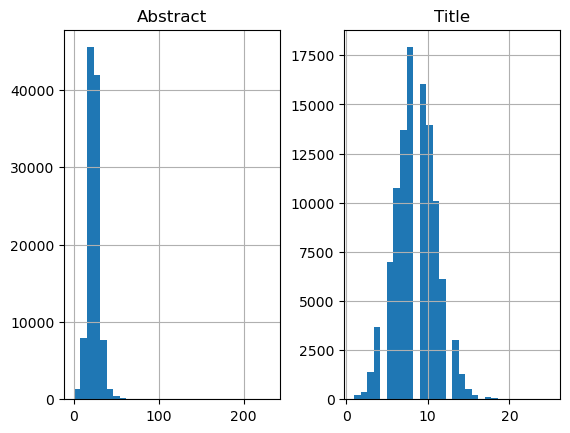

In [10]:
import matplotlib.pyplot as plt

abstract_word_count = []
title_word_count = []

# populate the lists with sentence lengths
for i in articles['Cleaned_abstract']:
      abstract_word_count.append(len(i.split()))

for i in articles['Cleaned_title']:
      title_word_count.append(len(i.split()))

length_df = pd.DataFrame({'Abstract':abstract_word_count, 'Title':title_word_count})

length_df.hist(bins = 30)
plt.show()

In [11]:
cnt=0
for i in articles['Cleaned_abstract']:
    if(len(i.split())<=35):
        cnt=cnt+1
print(cnt/len(articles['Cleaned_abstract']))

0.9686402643982499


In [12]:
max_abstract_len=36
max_title_len=13

In [13]:
cleaned_abstract = np.array(articles['Cleaned_abstract'])
cleaned_title = np.array(articles['Cleaned_title'])

short_abstract=[]
short_title=[]

for i in range(len(cleaned_abstract)):
    if(len(cleaned_title[i].split())<=max_title_len and len(cleaned_abstract[i].split())<=max_abstract_len):
        short_abstract.append(cleaned_abstract[i])
        short_title.append(cleaned_title[i])
        
df=pd.DataFrame({'abstract':short_abstract,'title':short_title})

In [14]:
df['title'] = df['title'].progress_apply(lambda x : 'sostok '+ x + ' eostok')

  0%|          | 0/101726 [00:00<?, ?it/s]

In [15]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['abstract']),np.array(df['title']),test_size=0.1,random_state=26,shuffle=True)

In [16]:
import tensorflow as tf

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(oov_token=True) 
x_tokenizer.fit_on_texts(list(x_tr))

In [18]:
thresh=2

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 42.67354579150292
Total Coverage of rare words: 1.0889662259342314


In [19]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt, oov_token='<unk>') # add 1 for OOV token
# x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr_seq    =   pad_sequences(x_tr_seq,  maxlen=max_abstract_len, padding='post')
x_val_seq   =   pad_sequences(x_val_seq, maxlen=max_abstract_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [20]:
x_voc

30779

In [21]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [22]:
thresh=2

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 42.89791564563093
Total Coverage of rare words: 1.5455003401554848


In [23]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt, oov_token='<unk>')  # add 1 for OOV token
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr_seq    =   pad_sequences(y_tr_seq, maxlen=max_title_len, padding='post')
y_val_seq  =   pad_sequences(y_val_seq, maxlen=max_title_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words + 1 # add 1,  for the padding token
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 19808


So the embedding pattern is as such:

    sostok : 2
    <unk>  : 1
    eostok : 3
    padding: 0

In [24]:
y_tokenizer.word_counts['sostok'],len(y_tr_seq)   

(91553, 91553)

In [25]:
# deleting the rows that contain only START and END tokens
ind=[]
for i in range(len(y_tr_seq)):
    cnt=0
    for j in y_tr_seq[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr_seq=np.delete(y_tr_seq,ind, axis=0)
x_tr_seq=np.delete(x_tr_seq,ind, axis=0)

In [26]:
# deleting the rows that contain only START and END tokens
ind=[]
for i in range(len(y_val_seq)):
    cnt=0
    for j in y_val_seq[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val_seq=np.delete(y_val_seq,ind, axis=0)
x_val_seq=np.delete(x_val_seq,ind, axis=0)

In [27]:
reverse_target_word_index=y_tokenizer.index_word # dictionary of token number to token for words in titles
reverse_source_word_index=x_tokenizer.index_word # dictionary of token number to token for words in abstracts
target_word_index=y_tokenizer.word_index         # dictionary of token to token number for words in titles

In [28]:
print(reverse_source_word_index)

{1: '<unk>', 2: 'the', 3: 'of', 4: 'in', 5: 'to', 6: 'and', 7: 'on', 8: 'that', 9: 'for', 10: 'an', 11: 'from', 12: 'is', 13: 'with', 14: 'was', 15: 'as', 16: 'by', 17: 'has', 18: 'president', 19: 'said', 20: 'his', 21: 'at', 22: 'have', 23: 'after', 24: 'are', 25: 'who', 26: 'but', 27: 'it', 28: 'were', 29: 'new', 30: 'he', 31: 'government', 32: 'be', 33: 'had', 34: 'its', 35: 'been', 36: 'their', 37: 'about', 38: 'united', 39: 'people', 40: 'two', 41: 'more', 42: 'minister', 43: 'over', 44: 'officials', 45: 'not', 46: 'state', 47: 'would', 48: 'american', 49: 'will', 50: 'they', 51: 'one', 52: 'prime', 53: 'states', 54: 'against', 55: 'see', 56: 'into', 57: 'than', 58: 'killed', 59: 'military', 60: 'election', 61: 'which', 62: 'mr', 63: 'year', 64: 'maps', 65: 'former', 66: 'some', 67: 'country', 68: 'police', 69: 'first', 70: 'international', 71: 'years', 72: 'political', 73: 'latest', 74: 'out', 75: 'could', 76: 'coronavirus', 77: 'her', 78: 'this', 79: 'party', 80: 'many', 81: 'la

In [29]:
print(target_word_index)

{'<unk>': 1, 'sostok': 2, 'eostok': 3, 'in': 4, 'to': 5, 'of': 6, 'the': 7, 'and': 8, 'on': 9, 'for': 10, 'u': 11, 'is': 12, 's': 13, 'at': 14, 'as': 15, 'with': 16, 'new': 17, 'china': 18, 'says': 19, 'from': 20, 'election': 21, 'after': 22, 'by': 23, 'over': 24, 'case': 25, 'trump': 26, 'leader': 27, 'are': 28, 'iran': 29, 'covid': 30, 'results': 31, 'risk': 32, 'south': 33, 'an': 34, 'n': 35, 'north': 36, 'president': 37, 'tracker': 38, 'russia': 39, 'county': 40, 'syria': 41, 'korea': 42, 'afghan': 43, 'but': 44, 'police': 45, 'attack': 46, 'war': 47, 'its': 48, 'obama': 49, 'pakistan': 50, 'chinese': 51, 'court': 52, 'israel': 53, 'killed': 54, 'it': 55, 'iraq': 56, 'talks': 57, 'his': 58, 'will': 59, 'against': 60, 'district': 61, 'be': 62, 'how': 63, 'more': 64, 'who': 65, 'may': 66, 'not': 67, 'military': 68, 'say': 69, 'up': 70, 'congressional': 71, 'nuclear': 72, 'dies': 73, 'afghanistan': 74, 'death': 75, 'india': 76, 'vote': 77, 'kills': 78, 'russian': 79, 'isis': 80, 'into

In [30]:
import tensorflow as tf

def getTensorFlowHashTable(inputDict):
    # Convert dictionary keys and values to tensors
    keyType    = tf.string
    valuesType = tf.string
    if type(list(inputDict.keys())[0]) == int:
        keyType = tf.int32
    if type(inputDict[list(inputDict.keys())[0]]) == int:
        valuesType = tf.int32
    keys_tensor = tf.constant(list(inputDict.keys()), dtype=keyType)
    values_tensor = tf.constant(list(inputDict.values()), dtype=valuesType)
    
    # Create a lookup table
    initializer = tf.lookup.KeyValueTensorInitializer(keys=keys_tensor, values=values_tensor)
    default = "UNKNOWN" if valuesType == tf.string else tf.constant(target_word_index["<unk>"])
    lookup_table = tf.lookup.StaticHashTable(initializer, default_value=default)
    return lookup_table

newDict = {}
for key in list(reverse_source_word_index.keys()):
    value = reverse_source_word_index[key]
    # if x word is in the y vocab
    if value in list(target_word_index.keys()):
        newDict[key] = target_word_index[value]       
    else:
        # if not, make it unknown
        newDict[key] = target_word_index["<unk>"]


reverse_source_word_index_tf = getTensorFlowHashTable(reverse_source_word_index)
target_word_index_tf = getTensorFlowHashTable(target_word_index)
simple_convert = getTensorFlowHashTable(newDict)

In [31]:
print(newDict)

{1: 1, 2: 7, 3: 6, 4: 4, 5: 5, 6: 8, 7: 9, 8: 83, 9: 10, 10: 34, 11: 20, 12: 12, 13: 16, 14: 131, 15: 15, 16: 23, 17: 104, 18: 37, 19: 191, 20: 58, 21: 14, 22: 154, 23: 22, 24: 28, 25: 65, 26: 44, 27: 55, 28: 630, 29: 17, 30: 129, 31: 87, 32: 62, 33: 864, 34: 48, 35: 898, 36: 157, 37: 92, 38: 705, 39: 369, 40: 190, 41: 64, 42: 107, 43: 24, 44: 91, 45: 67, 46: 111, 47: 584, 48: 124, 49: 59, 50: 298, 51: 144, 52: 225, 53: 460, 54: 60, 55: 392, 56: 81, 57: 292, 58: 54, 59: 68, 60: 21, 61: 1820, 62: 5691, 63: 196, 64: 4648, 65: 179, 66: 166, 67: 841, 68: 45, 69: 84, 70: 738, 71: 147, 72: 100, 73: 574, 74: 86, 75: 199, 76: 162, 77: 346, 78: 240, 79: 88, 80: 337, 81: 397, 82: 26, 83: 70, 84: 47, 85: 353, 86: 18, 87: 478, 88: 155, 89: 293, 90: 853, 91: 359, 92: 27, 93: 518, 94: 36, 95: 33, 96: 175, 97: 97, 98: 1, 99: 136, 100: 69, 101: 3128, 102: 135, 103: 153, 104: 638, 105: 49, 106: 46, 107: 66, 108: 283, 109: 180, 110: 11, 111: 63, 112: 446, 113: 52, 114: 498, 115: 606, 116: 158, 117: 110,

In [32]:
# tensor1 = tf.constant([1,2,3])
# print(tensor1)
# print(tensor1.shape)
# tensor2 = tf.constant([[1,2,3],
#                        [4,5,6],
#                        [7,8,9]])
# print(tensor2)
# print(tensor2.shape)



tensor = tf.constant([0, 0, 0, 0, 0, 0, 0, 0])   # tf.rank(tensor) == 1
indices = tf.constant([[1], [3], [4], [7]])       # num_updates == 4, index_depth == 1
indices_curr = tf.constant([1, 3, 4, 7])
indices_curr = tf.reshape(indices_curr, [4, -1])
updates = tf.constant([9, 10, 11, 12])        # num_updates == 4
print(tf.tensor_scatter_nd_update(tensor, indices_curr, updates))

print(tensor.shape)
print(indices.shape)
print(indices_curr.shape)
print(updates.shape)

tf.Tensor([ 0  9  0 10 11  0  0 12], shape=(8,), dtype=int32)
(8,)
(4, 1)
(4, 1)
(4,)


In [33]:
from pointer_generator import PointerGenerator, GetBestWord
from tensorflow.keras.layers import Lambda, Layer
from attention import AttentionLayer
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim = 100

# Encoder
encoder_inputs = Input(shape=(max_abstract_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])
# Attention layer
pointer_layer = PointerGenerator(name='Pointer_Generator')
pointer_out, pointer_states = pointer_layer([encoder_outputs, decoder_outputs])

pointer_dense = TimeDistributed(Dense(max_abstract_len, activation='softmax'), name="Pointer_step") # this gives the softmax dist for the title
pointer_dist = pointer_dense(pointer_out)

#dense layer
decoder_dense =  TimeDistributed(Dense(max_abstract_len, activation='softmax'), name="Decoder_out",)
decoder_outputs = decoder_dense(decoder_outputs)

best_word_layer = GetBestWord(simple_convert, max_abstract_len, y_voc)
best_dist = best_word_layer((pointer_dist, decoder_outputs, encoder_inputs))


max_layer =  TimeDistributed(Dense(y_voc, activation='softmax'), name="Pointer_Processed",)
pg_output = max_layer(best_dist)

# Define the model 
model = Model([encoder_inputs, decoder_inputs],  pg_output)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 36)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 36, 100)           │       3,077,900 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ [(None, 36, 300), (None,  │         481,200 │ embedding[0][0]            │
│                               │ 300), (None, 300)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ [(None, 36, 300), (None,  │         721,200 │ lstm[0][0]                 │
│                               │ 300), (None, 300)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_2 (LSTM)                 │ [(None, 36, 300), (None,  │         721,200 │ lstm_1[0][0]               │
│                               │ 300), (None, 300)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, None, 100)         │       1,980,800 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_3 (LSTM)                 │ [(None, None, 300),       │         481,200 │ embedding_1[0][0],         │
│                               │ (None, 300), (None, 300)] │                 │ lstm_2[0][1], lstm_2[0][2] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Pointer_Generator             │ [(None, None, 300),       │         180,300 │ lstm_2[0][0], lstm_3[0][0] │
│ (PointerGenerator)            │ (None, None, 36)]         │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Pointer_step                  │ (None, None, 36)          │          10,836 │ Pointer_Generator[0][0]    │
│ (TimeDistributed)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Decoder_out (TimeDistributed) │ (None, None, 36)          │          10,836 │ lstm_3[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_best_word (GetBestWord)   │ (None, None, 19844)       │               0 │ Pointer_step[0][0],        │
│                               │                           │                 │ Decoder_out[0][0],         │
│                               │                           │                 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Pointer_Processed             │ (None, None, 19808)       │     393,089,760 │ get_best_word[0][0]        │
│ (TimeDistributed)             │                           │               

 Total params: 400,755,232 (1.49 GB)

 Trainable params: 400,755,232 (1.49 GB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [35]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [36]:
print("Shapes of things")
print("X_rt shape",x_tr_seq.shape)
print("Y_rt shape",y_tr_seq.shape)
print("y_tr reshaped", y_tr_seq.reshape(y_tr_seq.shape[0],y_tr_seq.shape[1], 1).shape)
print("y_tr reshaped select", y_tr_seq.reshape(y_tr_seq.shape[0],y_tr_seq.shape[1], 1)[:,1:].shape)
print("X_val shape",x_val_seq.shape)
print("Y_val shape",y_val_seq.shape)
print("y_val reshaped", y_val_seq.reshape(y_val_seq.shape[0],y_val_seq.shape[1], 1).shape)
print("y_val reshaped select", y_val_seq.reshape(y_val_seq.shape[0],y_val_seq.shape[1], 1)[:,1:].shape)

Shapes of things
X_rt shape (91553, 36)
Y_rt shape (91553, 13)
y_tr reshaped (91553, 13, 1)
y_tr reshaped select (91553, 12, 1)
X_val shape (10173, 36)
Y_val shape (10173, 13)
y_val reshaped (10173, 13, 1)
y_val reshaped select (10173, 12, 1)


In [37]:
history=model.fit([x_tr_seq,y_tr_seq[:,:-1]], y_tr_seq.reshape(y_tr_seq.shape[0],y_tr_seq.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val_seq,y_val_seq[:,:-1]], y_val_seq.reshape(y_val_seq.shape[0],y_val_seq.shape[1], 1)[:,1:]))

Epoch 1/50
  2/716 ━━━━━━━━━━━━━━━━━━━━ 7:07:10 36s/step - loss: 9.8923

KeyboardInterrupt: 

In [ ]:
model.save_weights("LSTM_100k_attention_pointer.weights.h5")

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_abstract_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


# Attention layer
pointer_out, pointer_states = pointer_layer([decoder_hidden_state_input, decoder_outputs2])

pointer_dist = pointer_dense(pointer_out)

decoder_outputs2 = decoder_dense(decoder_outputs2)

best_dist = best_word_layer((pointer_dist, decoder_outputs2, decoder_hidden_state_input))

pg_output = max_layer(best_dist)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [pg_output] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        print(sampled_token_index)
        sampled_token_index = 1 if sampled_token_index == 0 else sampled_token_index
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_abstract_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2title(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2abstract(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(0,100):
    print("Abstract:",seq2abstract(x_tr_seq[i]))
    print("Original Title:",seq2title(y_tr_seq[i]))
    print("Predicted Title:",decode_sequence(x_tr_seq[i].reshape(1,max_abstract_len)))
    print("\n")